Found 8704 files belonging to 4 classes.
Found 1536 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.
Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.82357, saving model to efficientnetb0_finetuned.keras
1088/1088 - 168s - 154ms/step - accuracy: 0.6955 - loss: 0.6951 - val_accuracy: 0.8236 - val_loss: 0.4042 - learning_rate: 1.0000e-04
Epoch 2/15

Epoch 2: val_accuracy improved from 0.82357 to 0.84375, saving model to efficientnetb0_finetuned.keras
1088/1088 - 151s - 139ms/step - accuracy: 0.7923 - loss: 0.4876 - val_accuracy: 0.8438 - val_loss: 0.3456 - learning_rate: 1.0000e-04
Epoch 3/15

Epoch 3: val_accuracy improved from 0.84375 to 0.87695, saving model to efficientnetb0_finetuned.keras
1088/1088 - 141s - 129ms/step - accuracy: 0.8323 - loss: 0.4015 - val_accuracy: 0.8770 - val_loss: 0.2987 - learning_rate: 1.0000e-04
Epoch 4/15

Epoch 4: val_accuracy improved from 0.87695 to 0.90430, saving model to efficientnetb0_finetuned.keras
1088/1088 - 140s -

2025-05-20 20:58:57.220911: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


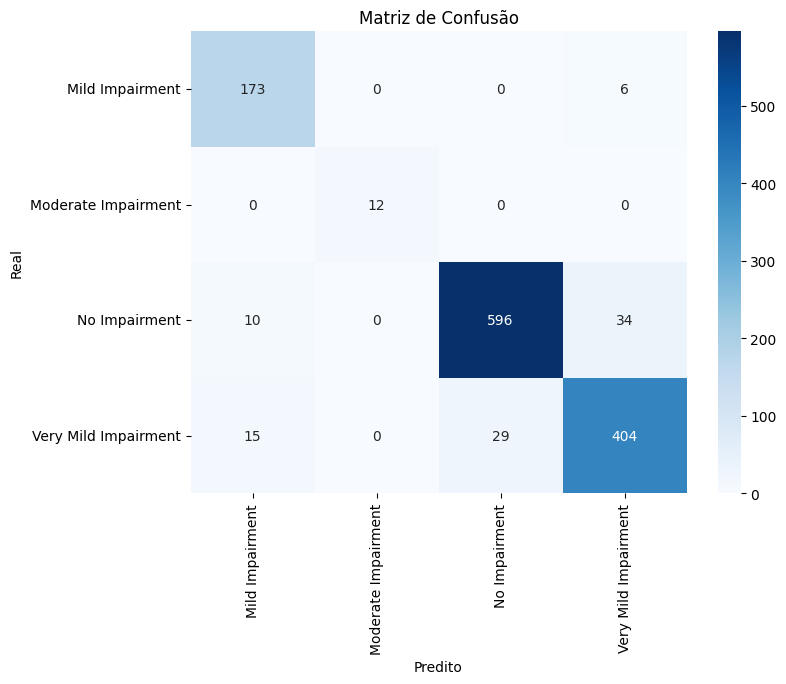


🔥 AUC Score (macro): 0.9911


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# ----------------------------
# CONFIGURAÇÕES
# ----------------------------
img_size = (224, 224)
batch_size = 8
epochs = 15

# ----------------------------
# Datasets
# ----------------------------
train_dir = './data/train'
val_dir = './data/val'
test_dir = './data/test'

train_ds_raw = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=img_size, batch_size=batch_size)
val_ds_raw = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=img_size, batch_size=batch_size)
test_ds_raw = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=img_size, batch_size=batch_size)

class_names = train_ds_raw.class_names
num_classes = len(class_names)

# Pré-processamento com normalização EfficientNet
train_ds = train_ds_raw.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds_raw.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds_raw.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)

# ----------------------------
# Pesos das classes
# ----------------------------
y_train = list(itertools.chain(*[y.numpy().tolist() for _, y in train_ds_raw]))
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# ----------------------------
# Modelo base EfficientNetB0
# ----------------------------
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Fine-tuning parcial: congela tudo menos as últimas 30 camadas
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.3)(x)  # regularização
output = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# ----------------------------
# Compilação
# ----------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1),
    ModelCheckpoint("efficientnetb0_finetuned.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
]

# ----------------------------
# Treinamento
# ----------------------------
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=2
)

# ----------------------------
# Avaliação
# ----------------------------
best_model = tf.keras.models.load_model("efficientnetb0_finetuned.keras")
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

# ----------------------------
# Métricas completas
# ----------------------------
y_true, y_pred, y_probs = [], [], []

for images, labels in test_ds:
    preds = best_model.predict(images)
    y_probs.extend(preds)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# AUC
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
auc = roc_auc_score(y_true_bin, np.array(y_probs), multi_class='ovr')
print(f"\n🔥 AUC Score (macro): {auc:.4f}")


In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import itertools

# ⚙️ Dataset e pré-processamento como antes
img_size = (224, 224)
batch_size = 8

train_dir = './data/train'
val_dir = './data/val'

train_ds_raw = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=img_size, batch_size=batch_size)
val_ds_raw = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=img_size, batch_size=batch_size)

from tensorflow.keras.applications.efficientnet import preprocess_input
train_ds = train_ds_raw.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds_raw.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)

# Pesos de classe novamente
class_names = train_ds_raw.class_names
num_classes = len(class_names)
y_train = list(itertools.chain(*[y.numpy().tolist() for _, y in train_ds_raw]))
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# 🔄 Carregar modelo salvo
model = load_model("efficientnetb0_finetuned.keras")

# ✅ Descongelar toda a EfficientNet
model.trainable = True

# Recompilar com LR menor para fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks (iguais ou mais agressivos)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
    ModelCheckpoint("efficientnetb0_finetuned_full.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
]

# 🔥 Segundo estágio de treino
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=2
)


Found 8704 files belonging to 4 classes.
Found 1536 files belonging to 4 classes.
Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.97461, saving model to efficientnetb0_finetuned_full.keras
1088/1088 - 139s - 128ms/step - accuracy: 0.9694 - loss: 0.0880 - val_accuracy: 0.9746 - val_loss: 0.0735 - learning_rate: 1.0000e-05
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.97461
1088/1088 - 127s - 117ms/step - accuracy: 0.9705 - loss: 0.0789 - val_accuracy: 0.9720 - val_loss: 0.0713 - learning_rate: 1.0000e-05
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.97461
1088/1088 - 123s - 113ms/step - accuracy: 0.9735 - loss: 0.0714 - val_accuracy: 0.9714 - val_loss: 0.0721 - learning_rate: 1.0000e-05
Epoch 4/10

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 4: val_accuracy did not improve from 0.97461
1088/1088 - 123s - 113ms/step - accuracy: 0.9753 - loss: 0.0712 - val_accuracy: 0.9714 - val_loss: 0.0730 - learning_rate: 1.0000e-05

In [ ]:
import matplotlib.pyplot as plt

# history = resultado de model.fit(...) do 2º estágio

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Treino')
    plt.plot(epochs_range, val_acc, label='Validação')
    plt.title('Acurácia por Época')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Treino')
    plt.plot(epochs_range, val_loss, label='Validação')
    plt.title('Loss por Época')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Execute
plot_history(history)
